In [13]:
import numpy as np
import scipy as sp
import json,sys,os
sys.path.append('../../')
import Project.profiles as pp
import Project.new_profiles as pnp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
import Project.quadrantHopping as qH
from tqdm.notebook import tqdm
from iminuit import Minuit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle

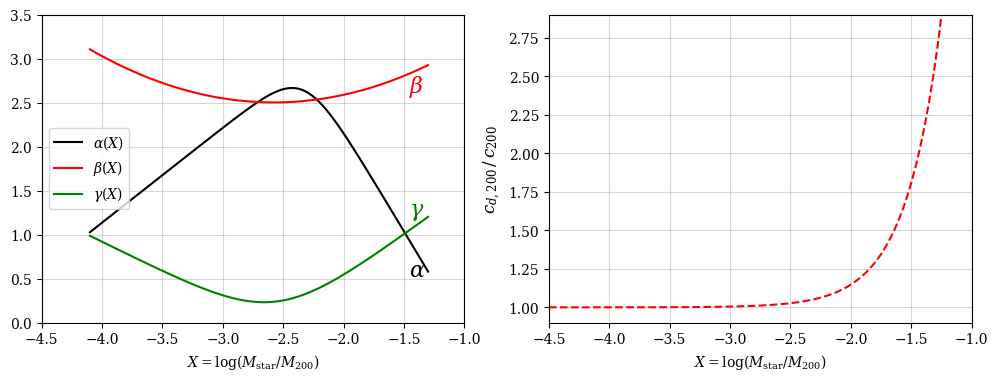

In [2]:
X = np.linspace(-4.1,-1.3,100)
A,B,C = [],[],[]
for x in X:
    a,b,c = pp.abc_dc14(x)
    A.append(a)
    B.append(b)
    C.append(c)
fig,axs = plt.subplots(1,2,figsize = (12,4))
ax1,ax2 = axs
ax1.plot(X,A,c = 'k',label = r'$\alpha(X)$')
ax1.plot(X,B,c = 'r',label = r'$\beta(X)$')
ax1.plot(X,C,c = 'g',label = r'$\gamma(X)$')
ax1.text(0.87,0.15,r'$\alpha$',size = 16, c = 'k',transform = ax1.transAxes)
ax1.text(0.87,0.75,r'$\beta$',size = 16, c = 'r',transform = ax1.transAxes)
ax1.text(0.87,0.35,r'$\gamma$',size = 16, c = 'g',transform = ax1.transAxes)
ax1.set_xlabel('$X = \mathrm{log}(M_{\mathrm{star}}/M_{200})$')
ax1.set_xlim(-4.5,-1)
ax1.set_ylim(0,3.5)
ax1.grid(alpha = 0.5)
ax1.legend()

X = np.linspace(-4.5,-1,100)
ax2.plot(X,pp.Csph_by_Cdm(X),c = 'r',ls = '--')
ax2.set_xlim(-4.5,-1)
ax2.set_ylim(0.9,2.9)
ax2.set_xlabel('$X = \mathrm{log}(M_{\mathrm{star}}/M_{200})$')
ax2.set_ylabel('$c_{d,200}\,/\,c_{200}$',size = 12)
ax2.grid(alpha = 0.5)

plt.savefig('../Output/figures/comparison/abc_dc14.pdf',bbox_inches = 'tight',dpi = 200)

In [3]:
LM = np.linspace(9.,13,9)
LS = pnp.lmstar_behroozi_19(LM)
C2 = 10**pp.lc200_SR(LM)

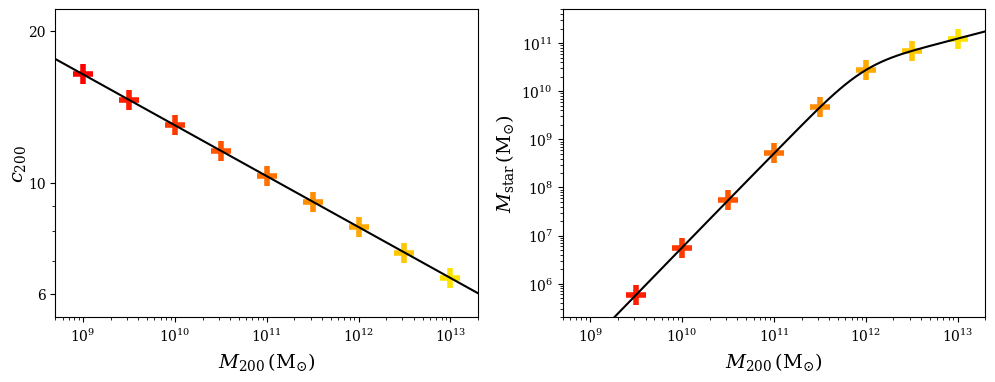

In [4]:
fig,axs = plt.subplots(1,2,figsize = (12,4))
ax1,ax2 = axs
cmap = 'autumn'

ax1.plot(10**np.linspace(8.,13.5,100),10**pp.lc200_SR(np.linspace(8.,13.5,100)), c = 'k')
ax2.plot(10**np.linspace(8.,13.5,100),10**pnp.lmstar_behroozi_19(np.linspace(8.,13.5,100)),c = 'k')

for i in range(9):
    ax1.scatter(10**LM[i],C2[i],s = 200, lw = 4, marker = '+', color = plt.get_cmap(cmap)((i/9)))
    ax2.scatter(10**LM[i],10**LS[i], marker = '+', s = 200,lw = 4, color = plt.get_cmap(cmap)(i/9))
    
ax1.set_ylabel('$c_{200}$',size = 14,labelpad = 0)
ax2.set_ylabel('$M_{\mathrm{star}} \, (\mathrm{M_{\odot}})$',size = 14)

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('$M_{200} \, (\mathrm{M_{\odot}})$',size = 14)
    ax.set_xlim(5e8,2e13)
    
ax2.set_ylim(2e5,5e11)
ax1.set_yticks([])
ax1.set_yticks([6,10,20])
ax1.set_yticklabels([6,10,20]);
plt.savefig('../Output/figures/comparison/mcr_shm.pdf',bbox_inches = 'tight',dpi = 300)

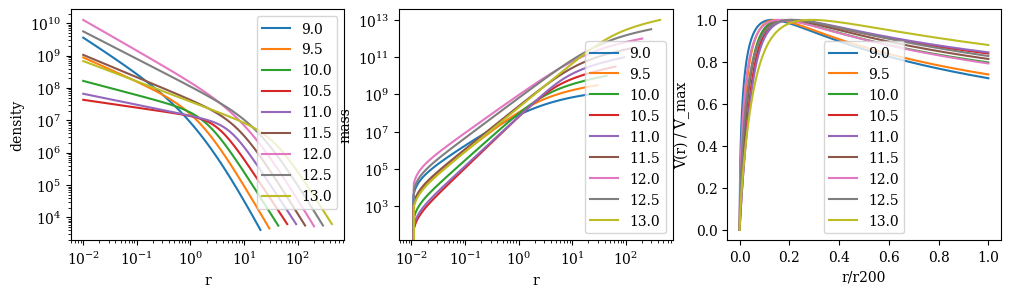

In [7]:
fig,axs = plt.subplots(1,3,figsize = (12,3))
ax1,ax2,ax3 = axs
for i in range(9):
    lm = LM[i]
    ls = LS[i]
    c2 = C2[i]
    r200 = pp.r200_nfw(lm)
    r = np.logspace(-2,np.log10(r200),100)
    a,b,c = pp.abc_dc14(ls-lm)
    rs = pp.rs_dc14(lm,c2,ls-lm,a,b,c)
    ax1.plot(r,pp.density_dc14(lm,ls,rs,r),label = '%.1f'%lm)
    ax2.plot(r,pp.mass_dc14(lm,ls,rs,r),label = '%.1f'%lm)
    ax3.plot(r/r200,pp.v_dc14(lm,ls,rs,r)/np.max(pp.v_dc14(lm,ls,rs,r)),label = '%.1f'%lm)


ax1.set_yscale('log')
ax1.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xscale('log')

ax1.set_xlabel('r')
ax2.set_xlabel('r')
ax3.set_xlabel('r/r200')
ax1.set_ylabel('density')
ax2.set_ylabel('mass')
ax3.set_ylabel('V(r) / V_max')
for ax in axs:
    ax.legend()

In [8]:
def get_nfw_params(r,v):
    nfw_func = lambda r,lm,rs: pp.v_nfw(lm,rs,r)
    popt,pcov = sp.optimize.curve_fit(nfw_func,r,v)
    return popt

def get_core_params(r,v,p0 = None,upp_bounds = [14,np.inf,np.inf]):
    core_func = lambda r,lm,rs,rc: pp.v_sidm(lm,rs,rc,r)
    popt,pcov = sp.optimize.curve_fit(core_func,r,v,p0 = p0,bounds = ([8,0.1,0.1],upp_bounds))
    return popt

def get_core_params2(logr,logrho, p0 = None, upp_bounds = [14,np.inf,np.inf]):
    core_func = lambda logr,lm,rs,rc: np.log10(pp.density_sidm(lm,rs,rc,10**logr))
    popt,pcov = sp.optimize.curve_fit(core_func,logr,logrho,p0 = p0,bounds = ([8.,0.1,0.1],upp_bounds))
    return popt

def get_Core_params(r,v):
    rs_core = lambda lm,c2: pp.r200_nfw(lm)/c2
    def min_func(lm,lc2,lrc):
        rc = 10**lrc
        lc2_mean = pp.lc200_SR(lm)
        rs = rs_core(lm,10**lc2)
        vmodel = pp.v_sidm(lm,rs,rc,r)
        chisq = (((v-vmodel))**2).sum()
        mc = ((lc2 - lc2_mean)/0.11)**2
        return chisq + mc
    m = Minuit(min_func,lm = 9., lc2 = 1, lrc = 1)
    m.limits['lm'] =( 8.,14.)
    m.limits['lc2'] = (0,2)
    m.limits['lrc'] = (-1,np.log10(200))
    m.errordef = Minuit.LIKELIHOOD
    min_res,m = qH.quadhop(m, ['lm','lc2','lrc'],[9.,1.,1.])
    res = min_res['globalmin']
    return res[0],rs_core(res[0],10**res[1]),10**res[2],min_res

1.233765284729627
2.0342260555835847
3.354021787152154
5.530094414931704
9.117992123726024
15.033699993231771
24.787489659964535
40.86948947494381
67.38541065900473


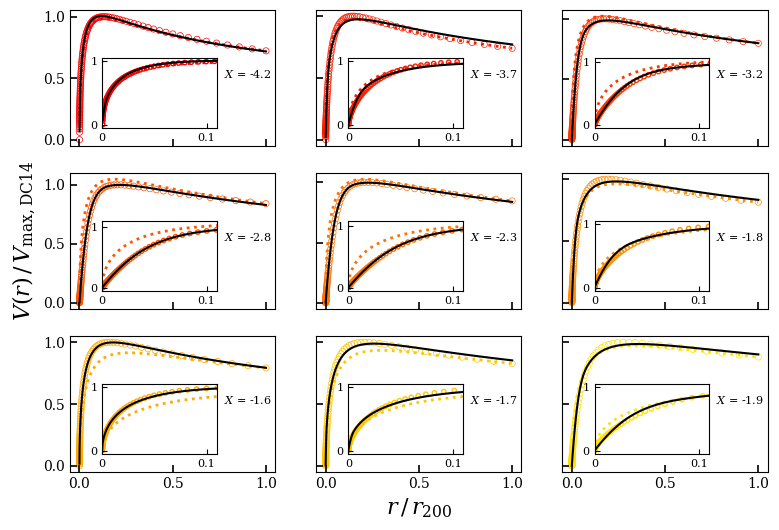

In [57]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
N = 9
cmap = 'autumn'
CP = []
dc14_vels = {}
for i in range(N):
    dc14_vels['vfit_%i'%i] = {}
    ax = axs[i]
    lm,ls,c2 = LM[i],LS[i],C2[i]
    a,b,c = pp.abc_dc14(ls-lm)
    rs_dc14 = pp.rs_dc14(lm,c2,ls-lm,a,b,c)
    r200 = pp.r200_nfw(lm)
    rs_nfw = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    vdc14 = pp.v_dc14(lm,ls,rs_dc14,r)
    vnfw = pp.v_nfw(lm,rs_nfw,r)
    vscale = np.max(vdc14)
    cp = get_core_params(r,vdc14,[9,1,1],[14,np.inf,5*rs_nfw])
    # cp = get_Core_params(r,vdc14)
    vbnfw = pp.v_sidm(*cp[0:3],r)
    dc14_vels['vfit_%i'%i]['dc14'] = lambda r: pp.v_dc14(lm,ls,rs_dc14,r)
    dc14_vels['vfit_%i'%i]['nfw'] = lambda r: pp.v_nfw(lm,rs_nfw,r)
    dc14_vels['vfit_%i'%i]['bnfw'] = lambda r: pp.v_sidm(*cp[:3],r)
    ax.scatter(r/r200,vdc14/vscale, color = plt.get_cmap(cmap)(i/9.),marker = 'o',
               facecolor = 'none', lw = 0.5, s = 20)
    # ax.plot(r/r200,vdc14/vscale, color = plt.get_cmap(cmap)(i/9.),lw = 2)
    ax.plot(r/r200,vnfw/vscale, color = plt.get_cmap(cmap)(i/9.), lw = 2, ls = ':')
    ax.plot(r/r200,vbnfw/vscale, color = 'k',lw = 1.5)
    ax.set_xlim(-0.05,1.05)
    if i%3:
        ax.set_yticklabels([])
    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
    if i == 3:
        ax.set_ylabel('$V(r)\,/\,V_{\mathrm{max,DC14}}$',size = 16)
    if i == 7:
        ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both',direction = 'in',width = 1.2, length = 5)
    inset_ax = inset_axes(ax,
                        width="70%", # width = 30% of parent_bbox
                        height=.7, # height : 1 inch
                        bbox_to_anchor = (-0.05,-0.3,0.8,1),bbox_transform = ax.transAxes)
    inset_ax.scatter(r/r200,vdc14/vscale,color = plt.get_cmap(cmap)(i/9.),lw = 1,
                    marker = 'o', facecolor = 'none',s = 10)
    inset_ax.plot(r/r200,vnfw/vscale,color = plt.get_cmap(cmap)(i/9.),lw =2,ls = ':')
    inset_ax.plot(r/r200,vbnfw/vscale,color = 'k')
    inset_ax.set_xlim(0,0.11)
    inset_ax.tick_params(which = 'both', direction = 'in',labelsize = 8)
    inset_ax.set_yticks([0,1])
    inset_ax.set_yticklabels([0,1])
    inset_ax.set_xticks([0,0.1])
    inset_ax.set_xticklabels([0,0.1])
    CP.append(cp)    
    ax.text(0.75,0.5,'$X$ = %.1f'%(ls-lm),size = 8,transform = ax.transAxes)
    
dc14_vels['CP_vels'] = CP
# plt.savefig('../Output/figures/comparison/DC14_RC.pdf',bbox_inches = 'tight',dpi = 300)

In [50]:
with open('../Output/data/DC14_BNFW_vfit.pkl','wb') as outp:
    dill.dump(dc14_vels, outp, pickle.HIGHEST_PROTOCOL)

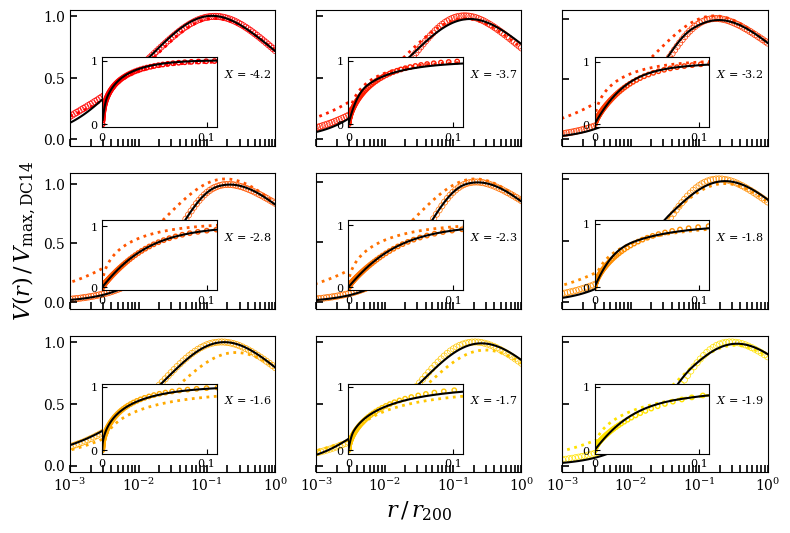

In [48]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
N = 9
cmap = 'autumn'
CP = []
for i in range(N):
    ax = axs[i]
    lm,ls,c2 = LM[i],LS[i],C2[i]
    a,b,c = pp.abc_dc14(ls-lm)
    rs_dc14 = pp.rs_dc14(lm,c2,ls-lm,a,b,c)
    r200 = pp.r200_nfw(lm)
    rs_nfw = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    vdc14 = pp.v_dc14(lm,ls,rs_dc14,r)
    vnfw = pp.v_nfw(lm,rs_nfw,r)
    vscale = np.max(vdc14)
    cp = get_core_params(r,vdc14,[9,1,1],[14,np.inf,5*rs_nfw])
    # cp = get_Core_params(r,vdc14)
    vbnfw = pp.v_sidm(*cp[0:3],r)

    ax.scatter(r/r200,vdc14/vscale, color = plt.get_cmap(cmap)(i/9.),marker = 'o',
               facecolor = 'none', lw = 0.5, s = 20)
    # ax.plot(r/r200,vdc14/vscale, color = plt.get_cmap(cmap)(i/9.),lw = 2)
    ax.plot(r/r200,vnfw/vscale, color = plt.get_cmap(cmap)(i/9.), lw = 2, ls = ':')
    ax.plot(r/r200,vbnfw/vscale, color = 'k',lw = 1.5)
    # ax.set_xlim(-0.05,1.05)
    ax.set_xscale('log')
    ax.set_xlim(1e-3,1)
    if i%3:
        ax.set_yticklabels([])
    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
    if i == 3:
        ax.set_ylabel('$V(r)\,/\,V_{\mathrm{max,DC14}}$',size = 16)
    if i == 7:
        ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both',direction = 'in',width = 1.2, length = 5)
    inset_ax = inset_axes(ax,
                        width="70%", # width = 30% of parent_bbox
                        height=.7, # height : 1 inch
                        bbox_to_anchor = (-0.05,-0.3,0.8,1),bbox_transform = ax.transAxes)
    inset_ax.scatter(r/r200,vdc14/vscale,color = plt.get_cmap(cmap)(i/9.),lw = 1,
                    marker = 'o', facecolor = 'none',s = 10)
    inset_ax.plot(r/r200,vnfw/vscale,color = plt.get_cmap(cmap)(i/9.),lw =2,ls = ':')
    inset_ax.plot(r/r200,vbnfw/vscale,color = 'k')
    inset_ax.set_xlim(0,0.11)
    inset_ax.tick_params(which = 'both', direction = 'in',labelsize = 8)
    inset_ax.set_yticks([0,1])
    inset_ax.set_yticklabels([0,1])
    inset_ax.set_xticks([0,0.1])
    inset_ax.set_xticklabels([0,0.1])
    CP.append(cp)    
    ax.text(0.75,0.5,'$X$ = %.1f'%(ls-lm),size = 8,transform = ax.transAxes)
    
# plt.savefig('../Output/figures/comparison/DC14_RC.pdf',bbox_inches = 'tight',dpi = 300)

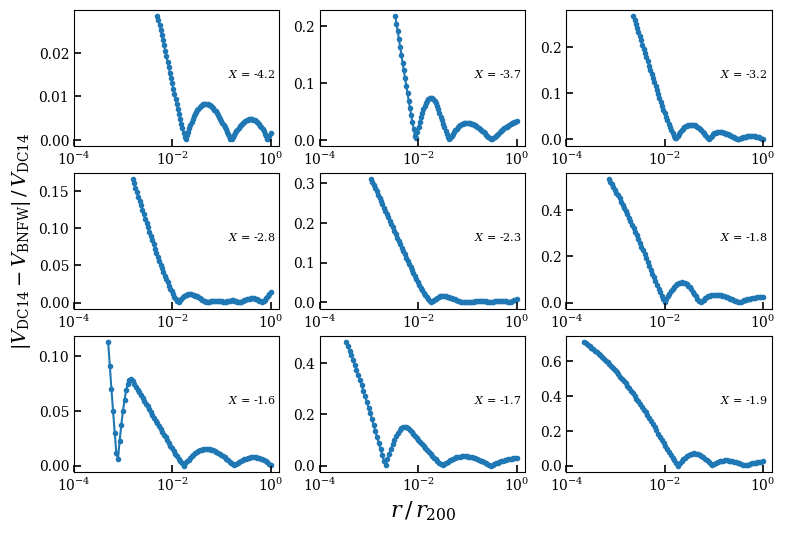

In [365]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
N = 9
cmap = 'autumn'
CP = []
minimas = []
for i in range(N):
    ax = axs[i]
    lm,ls,c2 = LM[i],LS[i],C2[i]
    a,b,c = pp.abc_dc14(ls-lm)
    rs_dc14 = pp.rs_dc14(lm,c2,ls-lm,a,b,c)
    r200 = pp.r200_nfw(lm)
    rs_nfw = r200/c2
    r = np.logspace(-1,np.log10(r200),100)
    ρdc14 = pp.v_dc14(lm,ls,rs_dc14,r)
    vnfw = pp.v_nfw(lm,rs_nfw,r)
    vscale = np.max(vdc14)
    cp = get_core_params(r,vdc14,[9,1,1],[14,np.inf,5*rs_nfw])
    # cp = get_Core_params(r,vdc14)
    vbnfw = pp.v_sidm(*cp[0:3],r)
    ax.set_xlim(-0.05,1.05)

    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
    if i == 3:
        ax.set_ylabel('$|V_{\mathrm{DC14}}-V_{\mathrm{BNFW}}|\,/\,V_{\mathrm{DC14}}$',size = 14)
    if i == 7:
        ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both',direction = 'in',width = 1.2, length = 5)

    CP.append(cp)
    diff = np.abs(vdc14-vbnfw)/vdc14
    idx = np.where(diff==np.max(diff))[0]
    # print (diff[idx]*100)
    # print (vdc14[idx],vbnfw[idx])
    # PLEASE WRITE THE MAXIMUM VALUE OF diff INSIDM EACH PANEL
    ax.scatter(r/r200,diff, marker = '.')
    ax.plot(r/r200,diff)
    ax.set_xscale('log')
    ax.set_xlim(1e-4,1.5)
    ax.text(0.75,0.5,'$X$ = %.1f'%(ls-lm),size = 8,transform = ax.transAxes)
    
# plt.savefig('../Output/figures/comparison/DC14_RC.pdf',bbox_inches = 'tight',dpi = 300)

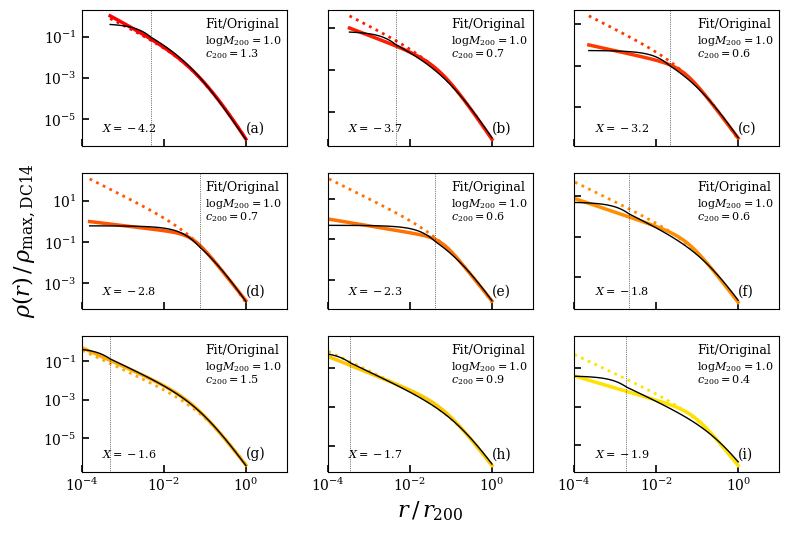

In [68]:
fig,axs = plt.subplots(3,3,figsize = (9,6))
axs = axs.flatten()
N = 9
panels = ['a','b','c','d','e','f','g','h','i']
cmap = 'autumn'
dc14_dens = {}
CP_dens = []
for i in range(N):
    dc14_dens['ρfit_%i'%i] = {}
    ax = axs[i]
    lm,ls,c2 = LM[i],LS[i],C2[i]
    a,b,c = pp.abc_dc14(ls-lm)
    rs_dc14 = pp.rs_dc14(lm,c2,ls-lm,a,b,c)
    r200 = pp.r200_nfw(lm)
    rs_nfw = r200/c2
    r = np.logspace(-2,np.log10(r200),100)
    ρdc14 = pp.density_dc14(lm,ls,rs_dc14,r)
    ρnfw = pp.density_nfw(lm,rs_nfw,r)

    ρscale = np.max(ρdc14)
    cp = get_core_params2(np.log10(r),np.log10(ρdc14),[9,1,1],[14,np.inf,5*rs_nfw])
    CP_dens.append(cp.tolist())
    ρbnfw = pp.density_sidm(*cp[0:3],r)
    dc14_dens['ρfit_%i'%i]['dc14'] = lambda r: pp.density_dc14(lm,ls,rs_dc14,r)
    dc14_dens['ρfit_%i'%i]['Nfw'] = lambda r: pp.density_nfw(lm,rs_nfw,r)
    dc14_dens['ρfit_%i'%i]['bnfw'] = lambda r: pp.density_sidm(*cp[0:3],r)

    # ax.scatter(r/r200,ρdc14/ρscale, color = plt.get_cmap(cmap)(i/9.),marker = 'o',
    #            facecolor = 'none', lw = 1.5, s = 20)
    # ax.plot(r/r200,ρnfw)
    ax.plot(r/r200,ρdc14/ρscale, color = plt.get_cmap(cmap)(i/9.),lw = 2.5)
    ax.plot(r/r200,ρnfw/ρscale, color = plt.get_cmap(cmap)(i/9.), lw = 2, ls = ':')
    ax.plot(r/r200,ρbnfw/ρscale, color = 'k',lw = 1)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(1e-4,1e1)
    if i%3:
        ax.set_yticklabels([])
    if i in [0,1,2,3,4,5]:
        ax.set_xticklabels([])
    if i == 3:
        ax.set_ylabel(r'$\rho(r)\,/\,\rho_{\mathrm{max,DC14}}$',size = 16)
    if i == 7:
        ax.set_xlabel('$r\,/\,r_{200}$',size = 16)
    ax.tick_params(which = 'both',direction = 'in',width = 1.2, length = 5)
    ax.text(0.6,0.87,'Fit/Original',size = 9,transform = ax.transAxes)
    ax.text(0.6,0.75,'$\mathrm{log}M_{200}=%.1f$'%(cp[0]/lm),size = 8, transform = ax.transAxes)
    ax.text(0.6,0.65,'$c_{200} = %.1f$'%(pnp.c200_nfw(cp[0],cp[1])/c2),size = 8, transform = ax.transAxes)
    ax.text(0.1,0.1,'$X = %.1f$'%(ls-lm),size = 8, transform = ax.transAxes)
    ax.text(0.8,0.1,'(%s)'%panels[i], size = 10, transform = ax.transAxes)
    ylim = ax.get_ylim()
    ax.plot([cp[2]/r200,cp[2]/r200],ylim, c = 'k', ls = ':',lw = 0.5)
    ax.set_ylim(ylim)

dc14_dens['CP_dens'] = CP_dens
# plt.savefig('../Output/figures/comparison/DC14_density.pdf',bbox_inches = 'tight',dpi = 300)

In [19]:
import dill
import pickle

In [69]:
with open('../Output/data/DC14_BNFW_ρfit.pkl','wb') as outp:
    dill.dump(dc14_dens,outp,pickle.HIGHEST_PROTOCOL)

In [34]:
L_M = np.linspace(9,13,100)
L_S = pnp.lmstar_behroozi_19(L_M)
C_2 = 10**pp.lc200_SR(L_M)
C_D,C_B,C_P = [],[],[]
R_S,R_D = [],[]
X = []
for i in range(100):
    lm,ls,c2 = L_M[i],L_S[i],C_2[i]
    a,b,c = pp.abc_dc14(ls-lm)
    rs_dc14 = pp.rs_dc14(lm,c2,ls-lm,a,b,c)
    r200 = pp.r200_nfw(lm)
    rs_nfw = r200/c2
    c200_dc14 = pp.Csph_by_Cdm(ls-lm)*c2
    C_D.append(c200_dc14)
    r = np.logspace(-2,np.log10(r200),100)
    vdc14 = pp.v_dc14(lm,ls,rs_dc14,r)
    cp = get_core_params(r,vdc14,[9,1,1],[14,np.inf,5*rs_nfw])
    # cp = get_Core_params(r,vdc14)
    c2_bnfw = pp.r200_nfw(cp[0])/cp[1]
    C_B.append(c2_bnfw)
    C_P.append(cp)
    R_S.append(rs_nfw)
    R_D.append(rs_dc14)
    X.append(ls-lm)
C_D = np.array(C_D)
C_B = np.array(C_B)
R_S = np.array(R_S)
R_D = np.array(R_D)

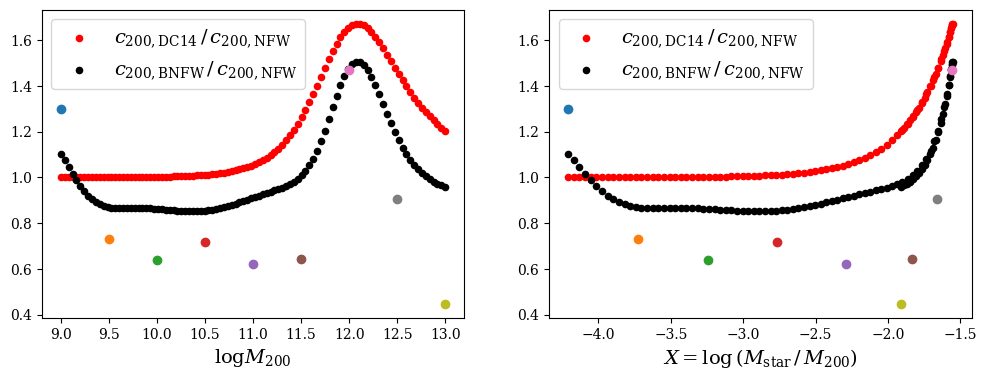

In [40]:
fig,axs = plt.subplots(1,2,figsize = (12,4))
ax1,ax2 = axs
ax1.scatter(L_M,C_D/C_2,c = 'r',label = r'$c_{200,\mathrm{DC14}}\,/\,c_{200,\mathrm{NFW}}$',
           marker = 'o',s = 20)
ax1.scatter(L_M,C_B/C_2,c = 'k',label = r'$c_{200,\mathrm{BNFW}}\,/\,c_{200,\mathrm{NFW}}$',
           marker = 'o',s = 20)
ax1.legend(prop = {'size':14})
ax1.set_xlabel('$\mathrm{log}M_{200}$',size = 14)

ax2.scatter(X,C_D/C_2,c = 'r',label = r'$c_{200,\mathrm{DC14}}\,/\,c_{200,\mathrm{NFW}}$',
            marker = 'o',s = 20)
ax2.scatter(X,C_B/C_2,c = 'k',label = r'$c_{200,\mathrm{BNFW}}\,/\,c_{200,\mathrm{NFW}}$',
            marker = 'o', s =20)
ax2.legend(prop = {'size':14})
ax2.set_xlabel('$X = \mathrm{log}\,(M_{\mathrm{star}}\,/\,M_{200})$',size = 14)

for i in range(9):
    cp = CP_dens[i]
    new_c2 = pnp.c200_nfw(*cp[:2])
    ax1.scatter(LM[i],new_c2/C2[i])
    ax2.scatter(LS[i]-LM[i],new_c2/C2[i])

# plt.savefig('../Output/figures/comparison/c200_comparison.pdf',bbox_inches = 'tight',dpi = 300)